<a href="https://colab.research.google.com/github/MitraDP/Detection-of-Surface-Defects-in-Magnetic-Tile-Images/blob/master/SurfaceDefectDetection_MagneticTile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Surface Defect Detection of Magnetic Tile

##Install the NVIDIA System Management Interface


In [1]:
!ls -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi
!nvcc --version

/opt/bin/nvidia-smi  /usr/bin/nvidia-smi
Mon Mar 15 18:13:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

##Download datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!wget -O data.zip https://github.com/abin24/Magnetic-tile-defect-datasets./archive/master.zip
!unzip data.zip

In [4]:
!mv Magnetic-tile-defect-datasets.-master data

##Library imports and the environment setting

In [5]:
%%capture
import numpy as np
import pandas as pd
              
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile, Image
#ImageFile.LOAD_TRUNCATED_IMAGES = True

!pip install torch
!pip install torchvision
!pip install torchsummary
import torch
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

import os
from glob import glob
import random
from random import shuffle
from tqdm import tqdm

!pip install torch-lr-finder
from torch_lr_finder import LRFinder

In [6]:
from transforms import Resize, Rotate, VerticalFlip, HorizontalFlip, Normalize, ToTensor
from dataset import SurfaceDefectDetectionDataset, partitioning
from loss import WeightedBCELoss, TverskyLoss
from unet import UNet_2D
from metrics import performance_metrics 
from train import train_2D
from inference import plot_prediction_results, get_inference_performance_metrics

In [7]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is available. Training on GPU ...


In [8]:
##Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(51)

##Set the parameters

In [9]:
batch_size = 32    # batch_size for the train and validation set
test_batch_size =1 # batch_size for the test set
num_workers = 0
n_epochs = 200
optimizer_type = 'Adam' """Either Adam or SGD, adjust the learning rate in the
                           "Specify the loss function and optimizer" section"""
threshold = 0.5   # Threshold value to create binary image 
lr_find = False   # Set to True to find the maximum learning rate
criterion_type = 'TverskyLoss'  """ Adjust the penalties in the "Specify the loss 
                                  function and optimizer" section"""  
classes =['Blowhole', 'Crack','Free'] # classes/labels
split_ratio = [0.70, 0.10, 0.20]      # A list of the (train,val,test) split ratio

## Dataset

In [10]:
partition = partitioning(split_ratio)

Blowhole _  train:  80   val:  11   test:  24   total:  115
Crack _  train:  39   val:  6   test:  12   total:  57
Free _  train:  56   val:  7   test:  17   total:  80


In [11]:
# Construct the transformed dataset
surface_defect_dataset ={}
for p in ['train', 'val', 'test']:
    surface_defect_dataset[p] = SurfaceDefectDetectionDataset (partition[p], p)

### Visualize sample images along with their masks

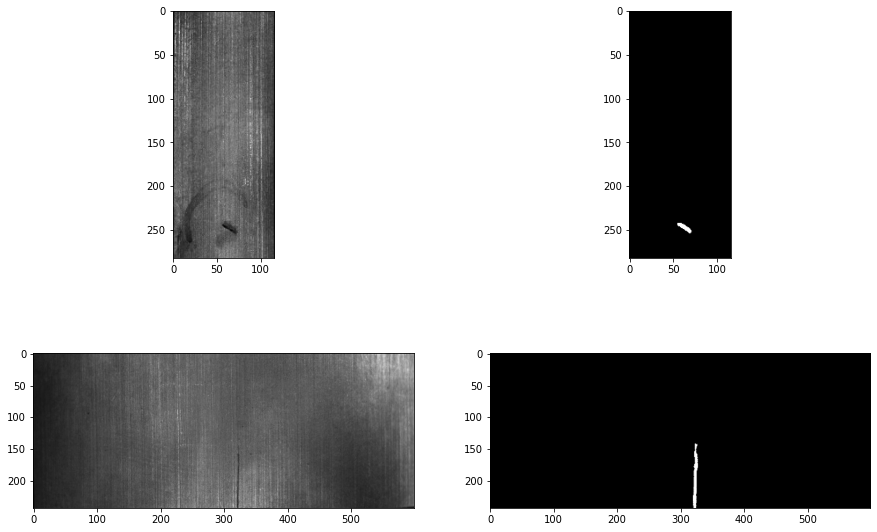

In [12]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944','data/MT_Crack/Imgs/exp1_num_86828']
#Define the size of images
fig =  plt.figure(figsize=(15, 10))
n=len(images_path)
for i, im_path in enumerate(images_path):
    ax = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(Image.open(im_path+'.jpg'), cmap='gray')
    ax = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(Image.open(im_path+'.png'), cmap='gray')

###Visualize transforms on sample images and masks


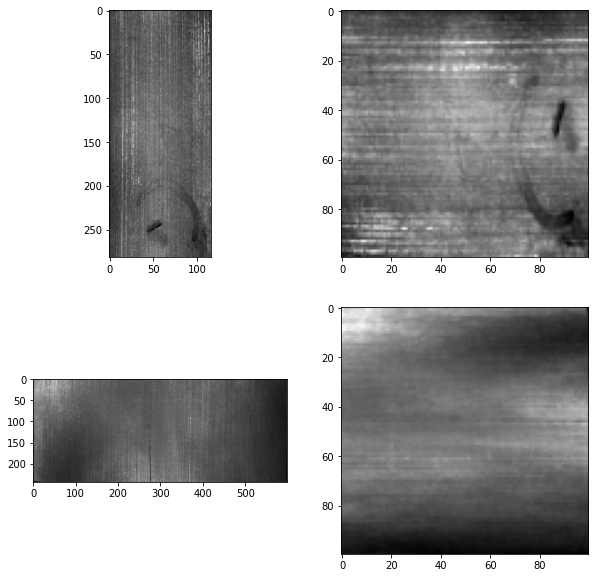

In [13]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944',
            'data/MT_Crack/Imgs/exp1_num_86828']
#Define the size of images
fig =  plt.figure(figsize=(10, 10))
n=len(images_path)
for i, im_path in enumerate(images_path):
    image = Image.open(images_path[i]+'.jpg')
    mask = Image.open(images_path[i]+'.png')
    t1 = HorizontalFlip()
    t2 = Resize((100,100))
    t3 = Rotate(90)
    ax1 = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(t1(image), cmap='gray')  # Added by Ray
    ax2 = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(t3(t2(image)), cmap='gray')


### Some stats about the dataset

In [14]:
#fing the range of height and width of train images
H = []
W = []
pair = []
for p in partition['train']:
  image = Image.open(p)
  W.append(image.size[0])
  H.append(image.size[1])
  pair.append(image.size)
print("maximum height:",max(H),"\tmaximum width:", max(W), "\tminimum height:", min(H), "\tminimum width:", min(W))

maximum height: 403 	maximum width: 609 	minimum height: 231 	minimum width: 113


In [15]:
print('Length of train dataset: ', len(surface_defect_dataset['train']))
print('Length of validation dataset: ', len(surface_defect_dataset['val']))
print('Length of test dataset: ', len(surface_defect_dataset['test']))

Length of train dataset:  175
Length of validation dataset:  24
Length of test dataset:  53


In [16]:
#find the weight of positive and negative pixels
positive_weight = 0
negative_weight = 0
total_pixels = 0
for _, target in surface_defect_dataset['train']:
    positive_weight += ((target.cpu().numpy()) >= threshold).sum()
    negative_weight += ((target.cpu().numpy()) < threshold).sum()
    total_pixels += (224 * 224)
positive_weight /= total_pixels
negative_weight /= total_pixels
print('positive weight = ',positive_weight, '\tnegative weight = ', negative_weight)

positive weight =  0.0020358053935860057 	negative weight =  0.997964194606414


## Batch and load data

In [17]:
# Generators: load data in batches
loaders={}
loaders['train'] = torch.utils.data.DataLoader(surface_defect_dataset['train'], 
                                               batch_size=batch_size,
                                               shuffle = True,
                                               num_workers=num_workers)
loaders['val'] = torch.utils.data.DataLoader(surface_defect_dataset['val'], 
                                             batch_size=batch_size,
                                             shuffle=False, 
                                             num_workers=num_workers)
loaders['test'] = torch.utils.data.DataLoader(surface_defect_dataset['test'], 
                                              batch_size= test_batch_size, 
                                              shuffle=False, 
                                              num_workers=num_workers)


## Obtain model architecture

In [18]:
# instantiate the unet
model = UNet_2D(1,1,32,0.2).cuda()

In [19]:
# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

In [20]:
summary(model, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 224, 224]             288
       BatchNorm2d-2         [32, 32, 224, 224]              64
              SiLU-3         [32, 32, 224, 224]               0
            Conv2d-4         [32, 32, 224, 224]           9,216
       BatchNorm2d-5         [32, 32, 224, 224]              64
              SiLU-6         [32, 32, 224, 224]               0
         MaxPool2d-7         [32, 32, 112, 112]               0
           Dropout-8         [32, 32, 112, 112]               0
            Conv2d-9         [32, 64, 112, 112]          18,432
      BatchNorm2d-10         [32, 64, 112, 112]             128
             SiLU-11         [32, 64, 112, 112]               0
           Conv2d-12         [32, 64, 112, 112]          36,864
      BatchNorm2d-13         [32, 64, 112, 112]             128
             SiLU-14         [32, 64, 1

## Specify the loss function and optimizer

In [21]:
if criterion_type == 'WeightedBCE':
    weight = np.array([negative_weight, positive_weight])
    weight = torch.from_numpy(weight)
    criterion = WeightedBCELoss(weights=weight)
else:
    criterion = TverskyLoss(1e-10,0.3,.7)
# Optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [22]:
"""
If lr_find is True, after running this cell, assign the scheduler's max_lr to 
the suggested maximum lr and then set lr_find to False in the "Set the parameters"
section. Set the lr in the optimizer 1/10 of max_lr. Then re_run the code. 
"""
if lr_find == False:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02,
                                                    steps_per_epoch=len(loaders['train']),
                                                    epochs=n_epochs)     
else:
    #https://github.com/davidtvs/pytorch-lr-finder
    desired_batch_size, real_batch_size = batch_size, batch_size
    accumulation_steps = desired_batch_size // real_batch_size
    lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
    lr_finder.range_test(loaders['train'], end_lr=1, num_iter=100, step_mode='exp')
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state"""

## Train and validate the model

In [23]:
model = train_2D(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, 'model.pt')                

  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  0%|          | 1/201 [00:05<19:04,  5.72s/it]

Epoch: 1 	Training Loss: 0.9960 	Validation Loss: 0.9979
Validation loss decreased.  Saving model ...
=== Epoch #2 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  1%|          | 2/201 [00:07<15:28,  4.67s/it]

Epoch: 2 	Training Loss: 0.9934 	Validation Loss: 0.9978
Validation loss decreased.  Saving model ...
=== Epoch #3 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  1%|▏         | 3/201 [00:10<12:57,  3.93s/it]

Epoch: 3 	Training Loss: 0.9928 	Validation Loss: 0.9978
Validation loss decreased.  Saving model ...
=== Epoch #4 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  2%|▏         | 4/201 [00:12<11:12,  3.41s/it]

Epoch: 4 	Training Loss: 0.9924 	Validation Loss: 0.9976
Validation loss decreased.  Saving model ...
=== Epoch #5 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  2%|▏         | 5/201 [00:14<09:56,  3.05s/it]

Epoch: 5 	Training Loss: 0.9913 	Validation Loss: 0.9970
Validation loss decreased.  Saving model ...
=== Epoch #6 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  3%|▎         | 6/201 [00:16<09:04,  2.79s/it]

Epoch: 6 	Training Loss: 0.9919 	Validation Loss: 0.9953
Validation loss decreased.  Saving model ...
=== Epoch #7 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  3%|▎         | 7/201 [00:18<08:26,  2.61s/it]

Epoch: 7 	Training Loss: 0.9907 	Validation Loss: 0.9949
Validation loss decreased.  Saving model ...
=== Epoch #8 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  4%|▍         | 8/201 [00:21<07:59,  2.48s/it]

Epoch: 8 	Training Loss: 0.9909 	Validation Loss: 0.9932
Validation loss decreased.  Saving model ...
=== Epoch #9 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  4%|▍         | 9/201 [00:23<07:39,  2.39s/it]

Epoch: 9 	Training Loss: 0.9896 	Validation Loss: 0.9921
Validation loss decreased.  Saving model ...
=== Epoch #10 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  5%|▍         | 10/201 [00:25<07:25,  2.33s/it]

Epoch: 10 	Training Loss: 0.9902 	Validation Loss: 0.9911
Validation loss decreased.  Saving model ...
=== Epoch #11 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  5%|▌         | 11/201 [00:27<07:15,  2.29s/it]

Epoch: 11 	Training Loss: 0.9890 	Validation Loss: 0.9909
Validation loss decreased.  Saving model ...
=== Epoch #12 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  6%|▌         | 12/201 [00:29<07:07,  2.26s/it]

Epoch: 12 	Training Loss: 0.9885 	Validation Loss: 0.9898
Validation loss decreased.  Saving model ...
=== Epoch #13 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  6%|▋         | 13/201 [00:31<06:58,  2.22s/it]

Epoch: 13 	Training Loss: 0.9876 	Validation Loss: 0.9900
=== Epoch #14 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  7%|▋         | 14/201 [00:34<06:53,  2.21s/it]

Epoch: 14 	Training Loss: 0.9882 	Validation Loss: 0.9897
Validation loss decreased.  Saving model ...
=== Epoch #15 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  7%|▋         | 15/201 [00:36<06:46,  2.19s/it]

Epoch: 15 	Training Loss: 0.9866 	Validation Loss: 0.9899
=== Epoch #16 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  8%|▊         | 16/201 [00:38<06:43,  2.18s/it]

Epoch: 16 	Training Loss: 0.9860 	Validation Loss: 0.9895
Validation loss decreased.  Saving model ...
=== Epoch #17 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  8%|▊         | 17/201 [00:40<06:41,  2.18s/it]

Epoch: 17 	Training Loss: 0.9857 	Validation Loss: 0.9892
Validation loss decreased.  Saving model ...
=== Epoch #18 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  9%|▉         | 18/201 [00:42<06:39,  2.18s/it]

Epoch: 18 	Training Loss: 0.9852 	Validation Loss: 0.9873
Validation loss decreased.  Saving model ...
=== Epoch #19 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  9%|▉         | 19/201 [00:45<06:37,  2.18s/it]

Epoch: 19 	Training Loss: 0.9829 	Validation Loss: 0.9861
Validation loss decreased.  Saving model ...
=== Epoch #20 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 10%|▉         | 20/201 [00:47<06:32,  2.17s/it]

Epoch: 20 	Training Loss: 0.9821 	Validation Loss: 0.9865
=== Epoch #21 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 10%|█         | 21/201 [00:49<06:33,  2.19s/it]

Epoch: 21 	Training Loss: 0.9791 	Validation Loss: 0.9847
Validation loss decreased.  Saving model ...
=== Epoch #22 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 11%|█         | 22/201 [00:51<06:32,  2.19s/it]

Epoch: 22 	Training Loss: 0.9805 	Validation Loss: 0.9837
Validation loss decreased.  Saving model ...
=== Epoch #23 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 11%|█▏        | 23/201 [00:53<06:30,  2.19s/it]

Epoch: 23 	Training Loss: 0.9775 	Validation Loss: 0.9832
Validation loss decreased.  Saving model ...
=== Epoch #24 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 12%|█▏        | 24/201 [00:56<06:28,  2.20s/it]

Epoch: 24 	Training Loss: 0.9771 	Validation Loss: 0.9804
Validation loss decreased.  Saving model ...
=== Epoch #25 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 12%|█▏        | 25/201 [00:58<06:22,  2.18s/it]

Epoch: 25 	Training Loss: 0.9761 	Validation Loss: 0.9822
=== Epoch #26 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 13%|█▎        | 26/201 [01:00<06:24,  2.20s/it]

Epoch: 26 	Training Loss: 0.9724 	Validation Loss: 0.9795
Validation loss decreased.  Saving model ...
=== Epoch #27 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 13%|█▎        | 27/201 [01:02<06:19,  2.18s/it]

Epoch: 27 	Training Loss: 0.9683 	Validation Loss: 0.9824
=== Epoch #28 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 14%|█▍        | 28/201 [01:04<06:14,  2.17s/it]

Epoch: 28 	Training Loss: 0.9662 	Validation Loss: 0.9885
=== Epoch #29 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 14%|█▍        | 29/201 [01:06<06:13,  2.17s/it]

Epoch: 29 	Training Loss: 0.9618 	Validation Loss: 0.9721
Validation loss decreased.  Saving model ...
=== Epoch #30 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 15%|█▍        | 30/201 [01:08<06:09,  2.16s/it]

Epoch: 30 	Training Loss: 0.9589 	Validation Loss: 0.9733
=== Epoch #31 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 15%|█▌        | 31/201 [01:11<06:09,  2.17s/it]

Epoch: 31 	Training Loss: 0.9486 	Validation Loss: 0.9689
Validation loss decreased.  Saving model ...
=== Epoch #32 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 16%|█▌        | 32/201 [01:13<06:07,  2.18s/it]

Epoch: 32 	Training Loss: 0.9396 	Validation Loss: 0.9626
Validation loss decreased.  Saving model ...
=== Epoch #33 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 16%|█▋        | 33/201 [01:15<06:05,  2.18s/it]

Epoch: 33 	Training Loss: 0.9403 	Validation Loss: 0.9581
Validation loss decreased.  Saving model ...
=== Epoch #34 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 17%|█▋        | 34/201 [01:17<06:04,  2.18s/it]

Epoch: 34 	Training Loss: 0.9299 	Validation Loss: 0.9562
Validation loss decreased.  Saving model ...
=== Epoch #35 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 17%|█▋        | 35/201 [01:19<06:01,  2.18s/it]

Epoch: 35 	Training Loss: 0.9230 	Validation Loss: 0.9372
Validation loss decreased.  Saving model ...
=== Epoch #36 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 18%|█▊        | 36/201 [01:22<05:57,  2.17s/it]

Epoch: 36 	Training Loss: 0.9116 	Validation Loss: 0.9396
=== Epoch #37 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 18%|█▊        | 37/201 [01:24<05:56,  2.17s/it]

Epoch: 37 	Training Loss: 0.8906 	Validation Loss: 0.9244
Validation loss decreased.  Saving model ...
=== Epoch #38 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 19%|█▉        | 38/201 [01:26<05:55,  2.18s/it]

Epoch: 38 	Training Loss: 0.8698 	Validation Loss: 0.9143
Validation loss decreased.  Saving model ...
=== Epoch #39 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 19%|█▉        | 39/201 [01:28<05:53,  2.18s/it]

Epoch: 39 	Training Loss: 0.8538 	Validation Loss: 0.9084
Validation loss decreased.  Saving model ...
=== Epoch #40 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 20%|█▉        | 40/201 [01:30<05:51,  2.19s/it]

Epoch: 40 	Training Loss: 0.8480 	Validation Loss: 0.8861
Validation loss decreased.  Saving model ...
=== Epoch #41 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 20%|██        | 41/201 [01:32<05:49,  2.18s/it]

Epoch: 41 	Training Loss: 0.8007 	Validation Loss: 0.8674
Validation loss decreased.  Saving model ...
=== Epoch #42 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 21%|██        | 42/201 [01:35<05:47,  2.19s/it]

Epoch: 42 	Training Loss: 0.7741 	Validation Loss: 0.8047
Validation loss decreased.  Saving model ...
=== Epoch #43 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 21%|██▏       | 43/201 [01:37<05:46,  2.19s/it]

Epoch: 43 	Training Loss: 0.7324 	Validation Loss: 0.7886
Validation loss decreased.  Saving model ...
=== Epoch #44 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 22%|██▏       | 44/201 [01:39<05:43,  2.19s/it]

Epoch: 44 	Training Loss: 0.7113 	Validation Loss: 0.7132
Validation loss decreased.  Saving model ...
=== Epoch #45 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 22%|██▏       | 45/201 [01:41<05:41,  2.19s/it]

Epoch: 45 	Training Loss: 0.6518 	Validation Loss: 0.6974
Validation loss decreased.  Saving model ...
=== Epoch #46 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 23%|██▎       | 46/201 [01:43<05:39,  2.19s/it]

Epoch: 46 	Training Loss: 0.6101 	Validation Loss: 0.6732
Validation loss decreased.  Saving model ...
=== Epoch #47 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 23%|██▎       | 47/201 [01:46<05:36,  2.19s/it]

Epoch: 47 	Training Loss: 0.5876 	Validation Loss: 0.6184
Validation loss decreased.  Saving model ...
=== Epoch #48 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 24%|██▍       | 48/201 [01:48<05:34,  2.19s/it]

Epoch: 48 	Training Loss: 0.5513 	Validation Loss: 0.5977
Validation loss decreased.  Saving model ...
=== Epoch #49 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 24%|██▍       | 49/201 [01:50<05:32,  2.18s/it]

Epoch: 49 	Training Loss: 0.5000 	Validation Loss: 0.5772
Validation loss decreased.  Saving model ...
=== Epoch #50 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 25%|██▍       | 50/201 [01:52<05:30,  2.19s/it]

Epoch: 50 	Training Loss: 0.4675 	Validation Loss: 0.5334
Validation loss decreased.  Saving model ...
=== Epoch #51 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 25%|██▌       | 51/201 [01:54<05:27,  2.18s/it]

Epoch: 51 	Training Loss: 0.4320 	Validation Loss: 0.5240
Validation loss decreased.  Saving model ...
=== Epoch #52 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 26%|██▌       | 52/201 [01:56<05:22,  2.17s/it]

Epoch: 52 	Training Loss: 0.4271 	Validation Loss: 0.5361
=== Epoch #53 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 26%|██▋       | 53/201 [01:59<05:20,  2.17s/it]

Epoch: 53 	Training Loss: 0.3752 	Validation Loss: 0.5217
Validation loss decreased.  Saving model ...
=== Epoch #54 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 27%|██▋       | 54/201 [02:01<05:16,  2.15s/it]

Epoch: 54 	Training Loss: 0.3673 	Validation Loss: 0.6318
=== Epoch #55 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 27%|██▋       | 55/201 [02:03<05:15,  2.16s/it]

Epoch: 55 	Training Loss: 0.3447 	Validation Loss: 0.4233
Validation loss decreased.  Saving model ...
=== Epoch #56 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 28%|██▊       | 56/201 [02:05<05:14,  2.17s/it]

Epoch: 56 	Training Loss: 0.3475 	Validation Loss: 0.3580
Validation loss decreased.  Saving model ...
=== Epoch #57 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 28%|██▊       | 57/201 [02:07<05:10,  2.15s/it]

Epoch: 57 	Training Loss: 0.3346 	Validation Loss: 0.3596
=== Epoch #58 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 29%|██▉       | 58/201 [02:09<05:07,  2.15s/it]

Epoch: 58 	Training Loss: 0.3151 	Validation Loss: 0.4958
=== Epoch #59 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 29%|██▉       | 59/201 [02:12<05:07,  2.17s/it]

Epoch: 59 	Training Loss: 0.3359 	Validation Loss: 0.3576
Validation loss decreased.  Saving model ...
=== Epoch #60 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 30%|██▉       | 60/201 [02:14<05:06,  2.17s/it]

Epoch: 60 	Training Loss: 0.3283 	Validation Loss: 0.3569
Validation loss decreased.  Saving model ...
=== Epoch #61 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 30%|███       | 61/201 [02:16<05:04,  2.18s/it]

Epoch: 61 	Training Loss: 0.2981 	Validation Loss: 0.3434
Validation loss decreased.  Saving model ...
=== Epoch #62 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 31%|███       | 62/201 [02:18<05:02,  2.18s/it]

Epoch: 62 	Training Loss: 0.3072 	Validation Loss: 0.3393
Validation loss decreased.  Saving model ...
=== Epoch #63 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 31%|███▏      | 63/201 [02:20<04:58,  2.16s/it]

Epoch: 63 	Training Loss: 0.3006 	Validation Loss: 0.3851
=== Epoch #64 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 32%|███▏      | 64/201 [02:22<04:56,  2.17s/it]

Epoch: 64 	Training Loss: 0.3059 	Validation Loss: 0.3228
Validation loss decreased.  Saving model ...
=== Epoch #65 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 32%|███▏      | 65/201 [02:25<04:52,  2.15s/it]

Epoch: 65 	Training Loss: 0.3102 	Validation Loss: 0.3378
=== Epoch #66 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 33%|███▎      | 66/201 [02:27<04:49,  2.14s/it]

Epoch: 66 	Training Loss: 0.2676 	Validation Loss: 0.3404
=== Epoch #67 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 33%|███▎      | 67/201 [02:29<04:45,  2.13s/it]

Epoch: 67 	Training Loss: 0.2731 	Validation Loss: 0.3877
=== Epoch #68 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 34%|███▍      | 68/201 [02:31<04:44,  2.14s/it]

Epoch: 68 	Training Loss: 0.2982 	Validation Loss: 0.3364
=== Epoch #69 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 34%|███▍      | 69/201 [02:33<04:41,  2.13s/it]

Epoch: 69 	Training Loss: 0.2612 	Validation Loss: 0.3463
=== Epoch #70 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 35%|███▍      | 70/201 [02:35<04:39,  2.13s/it]

Epoch: 70 	Training Loss: 0.3114 	Validation Loss: 0.4265
=== Epoch #71 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 35%|███▌      | 71/201 [02:37<04:36,  2.13s/it]

Epoch: 71 	Training Loss: 0.2913 	Validation Loss: 0.3306
=== Epoch #72 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 36%|███▌      | 72/201 [02:39<04:34,  2.13s/it]

Epoch: 72 	Training Loss: 0.2953 	Validation Loss: 0.3302
=== Epoch #73 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 36%|███▋      | 73/201 [02:42<04:32,  2.13s/it]

Epoch: 73 	Training Loss: 0.3133 	Validation Loss: 0.3602
=== Epoch #74 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 37%|███▋      | 74/201 [02:44<04:30,  2.13s/it]

Epoch: 74 	Training Loss: 0.2836 	Validation Loss: 0.3740
=== Epoch #75 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 37%|███▋      | 75/201 [02:46<04:28,  2.13s/it]

Epoch: 75 	Training Loss: 0.2872 	Validation Loss: 0.3390
=== Epoch #76 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 38%|███▊      | 76/201 [02:48<04:26,  2.13s/it]

Epoch: 76 	Training Loss: 0.2997 	Validation Loss: 0.3278
=== Epoch #77 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 38%|███▊      | 77/201 [02:50<04:23,  2.13s/it]

Epoch: 77 	Training Loss: 0.2898 	Validation Loss: 0.3473
=== Epoch #78 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 39%|███▉      | 78/201 [02:52<04:23,  2.14s/it]

Epoch: 78 	Training Loss: 0.2836 	Validation Loss: 0.3036
Validation loss decreased.  Saving model ...
=== Epoch #79 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 39%|███▉      | 79/201 [02:54<04:20,  2.14s/it]

Epoch: 79 	Training Loss: 0.2591 	Validation Loss: 0.3313
=== Epoch #80 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 40%|███▉      | 80/201 [02:57<04:19,  2.15s/it]

Epoch: 80 	Training Loss: 0.2545 	Validation Loss: 0.2985
Validation loss decreased.  Saving model ...
=== Epoch #81 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 40%|████      | 81/201 [02:59<04:16,  2.14s/it]

Epoch: 81 	Training Loss: 0.2549 	Validation Loss: 0.3051
=== Epoch #82 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 41%|████      | 82/201 [03:01<04:15,  2.15s/it]

Epoch: 82 	Training Loss: 0.2432 	Validation Loss: 0.2770
Validation loss decreased.  Saving model ...
=== Epoch #83 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 41%|████▏     | 83/201 [03:03<04:14,  2.15s/it]

Epoch: 83 	Training Loss: 0.2788 	Validation Loss: 0.2596
Validation loss decreased.  Saving model ...
=== Epoch #84 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 42%|████▏     | 84/201 [03:05<04:10,  2.14s/it]

Epoch: 84 	Training Loss: 0.2414 	Validation Loss: 0.2892
=== Epoch #85 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 42%|████▏     | 85/201 [03:07<04:08,  2.14s/it]

Epoch: 85 	Training Loss: 0.2326 	Validation Loss: 0.3106
=== Epoch #86 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 43%|████▎     | 86/201 [03:09<04:05,  2.13s/it]

Epoch: 86 	Training Loss: 0.2360 	Validation Loss: 0.3059
=== Epoch #87 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 43%|████▎     | 87/201 [03:12<04:03,  2.13s/it]

Epoch: 87 	Training Loss: 0.2231 	Validation Loss: 0.3222
=== Epoch #88 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 44%|████▍     | 88/201 [03:14<04:00,  2.13s/it]

Epoch: 88 	Training Loss: 0.2318 	Validation Loss: 0.2709
=== Epoch #89 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 44%|████▍     | 89/201 [03:16<03:59,  2.13s/it]

Epoch: 89 	Training Loss: 0.2137 	Validation Loss: 0.2722
=== Epoch #90 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 45%|████▍     | 90/201 [03:18<03:56,  2.13s/it]

Epoch: 90 	Training Loss: 0.2437 	Validation Loss: 0.2798
=== Epoch #91 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 45%|████▌     | 91/201 [03:20<03:54,  2.13s/it]

Epoch: 91 	Training Loss: 0.2224 	Validation Loss: 0.2851
=== Epoch #92 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 46%|████▌     | 92/201 [03:22<03:51,  2.12s/it]

Epoch: 92 	Training Loss: 0.2174 	Validation Loss: 0.2817
=== Epoch #93 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 46%|████▋     | 93/201 [03:24<03:48,  2.12s/it]

Epoch: 93 	Training Loss: 0.2281 	Validation Loss: 0.3019
=== Epoch #94 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 47%|████▋     | 94/201 [03:26<03:46,  2.12s/it]

Epoch: 94 	Training Loss: 0.2163 	Validation Loss: 0.3021
=== Epoch #95 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 47%|████▋     | 95/201 [03:28<03:44,  2.12s/it]

Epoch: 95 	Training Loss: 0.2069 	Validation Loss: 0.3001
=== Epoch #96 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 48%|████▊     | 96/201 [03:31<03:42,  2.12s/it]

Epoch: 96 	Training Loss: 0.2281 	Validation Loss: 0.3018
=== Epoch #97 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 48%|████▊     | 97/201 [03:33<03:40,  2.12s/it]

Epoch: 97 	Training Loss: 0.2221 	Validation Loss: 0.2867
=== Epoch #98 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 49%|████▉     | 98/201 [03:35<03:39,  2.13s/it]

Epoch: 98 	Training Loss: 0.2117 	Validation Loss: 0.2461
Validation loss decreased.  Saving model ...
=== Epoch #99 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 49%|████▉     | 99/201 [03:37<03:38,  2.14s/it]

Epoch: 99 	Training Loss: 0.2106 	Validation Loss: 0.2361
Validation loss decreased.  Saving model ...
=== Epoch #100 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 50%|████▉     | 100/201 [03:39<03:37,  2.15s/it]

Epoch: 100 	Training Loss: 0.2202 	Validation Loss: 0.2290
Validation loss decreased.  Saving model ...
=== Epoch #101 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 50%|█████     | 101/201 [03:41<03:34,  2.15s/it]

Epoch: 101 	Training Loss: 0.2161 	Validation Loss: 0.2559
=== Epoch #102 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 51%|█████     | 102/201 [03:43<03:31,  2.14s/it]

Epoch: 102 	Training Loss: 0.1935 	Validation Loss: 0.2406
=== Epoch #103 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 51%|█████     | 103/201 [03:46<03:29,  2.13s/it]

Epoch: 103 	Training Loss: 0.2030 	Validation Loss: 0.2341
=== Epoch #104 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 52%|█████▏    | 104/201 [03:48<03:26,  2.13s/it]

Epoch: 104 	Training Loss: 0.2077 	Validation Loss: 0.2384
=== Epoch #105 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 52%|█████▏    | 105/201 [03:50<03:25,  2.14s/it]

Epoch: 105 	Training Loss: 0.1945 	Validation Loss: 0.2811
=== Epoch #106 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 53%|█████▎    | 106/201 [03:52<03:22,  2.13s/it]

Epoch: 106 	Training Loss: 0.2111 	Validation Loss: 0.2797
=== Epoch #107 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 53%|█████▎    | 107/201 [03:54<03:20,  2.13s/it]

Epoch: 107 	Training Loss: 0.2005 	Validation Loss: 0.2524
=== Epoch #108 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 54%|█████▎    | 108/201 [03:56<03:17,  2.13s/it]

Epoch: 108 	Training Loss: 0.2001 	Validation Loss: 0.2888
=== Epoch #109 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 54%|█████▍    | 109/201 [03:58<03:16,  2.13s/it]

Epoch: 109 	Training Loss: 0.2024 	Validation Loss: 0.2533
=== Epoch #110 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 55%|█████▍    | 110/201 [04:00<03:13,  2.13s/it]

Epoch: 110 	Training Loss: 0.2055 	Validation Loss: 0.2361
=== Epoch #111 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 55%|█████▌    | 111/201 [04:03<03:11,  2.12s/it]

Epoch: 111 	Training Loss: 0.1952 	Validation Loss: 0.2418
=== Epoch #112 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 56%|█████▌    | 112/201 [04:05<03:10,  2.14s/it]

Epoch: 112 	Training Loss: 0.2046 	Validation Loss: 0.2277
Validation loss decreased.  Saving model ...
=== Epoch #113 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 56%|█████▌    | 113/201 [04:07<03:08,  2.14s/it]

Epoch: 113 	Training Loss: 0.2047 	Validation Loss: 0.2319
=== Epoch #114 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 57%|█████▋    | 114/201 [04:09<03:05,  2.13s/it]

Epoch: 114 	Training Loss: 0.1980 	Validation Loss: 0.2393
=== Epoch #115 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 57%|█████▋    | 115/201 [04:11<03:03,  2.13s/it]

Epoch: 115 	Training Loss: 0.2081 	Validation Loss: 0.2381
=== Epoch #116 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 58%|█████▊    | 116/201 [04:13<03:00,  2.13s/it]

Epoch: 116 	Training Loss: 0.1985 	Validation Loss: 0.2495
=== Epoch #117 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 58%|█████▊    | 117/201 [04:15<02:58,  2.12s/it]

Epoch: 117 	Training Loss: 0.1885 	Validation Loss: 0.2899
=== Epoch #118 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 59%|█████▊    | 118/201 [04:18<02:56,  2.12s/it]

Epoch: 118 	Training Loss: 0.1990 	Validation Loss: 0.2998
=== Epoch #119 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 59%|█████▉    | 119/201 [04:20<02:53,  2.12s/it]

Epoch: 119 	Training Loss: 0.1923 	Validation Loss: 0.2897
=== Epoch #120 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 60%|█████▉    | 120/201 [04:22<02:51,  2.12s/it]

Epoch: 120 	Training Loss: 0.1926 	Validation Loss: 0.2870
=== Epoch #121 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 60%|██████    | 121/201 [04:24<02:50,  2.13s/it]

Epoch: 121 	Training Loss: 0.1941 	Validation Loss: 0.2937
=== Epoch #122 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 61%|██████    | 122/201 [04:26<02:48,  2.13s/it]

Epoch: 122 	Training Loss: 0.1996 	Validation Loss: 0.2861
=== Epoch #123 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 61%|██████    | 123/201 [04:28<02:45,  2.13s/it]

Epoch: 123 	Training Loss: 0.1995 	Validation Loss: 0.2837
=== Epoch #124 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 62%|██████▏   | 124/201 [04:30<02:43,  2.12s/it]

Epoch: 124 	Training Loss: 0.1950 	Validation Loss: 0.2652
=== Epoch #125 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 62%|██████▏   | 125/201 [04:32<02:41,  2.12s/it]

Epoch: 125 	Training Loss: 0.1891 	Validation Loss: 0.2558
=== Epoch #126 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 63%|██████▎   | 126/201 [04:35<02:39,  2.12s/it]

Epoch: 126 	Training Loss: 0.1942 	Validation Loss: 0.2597
=== Epoch #127 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 63%|██████▎   | 127/201 [04:37<02:36,  2.12s/it]

Epoch: 127 	Training Loss: 0.1939 	Validation Loss: 0.2912
=== Epoch #128 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 64%|██████▎   | 128/201 [04:39<02:35,  2.13s/it]

Epoch: 128 	Training Loss: 0.1985 	Validation Loss: 0.2852
=== Epoch #129 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 64%|██████▍   | 129/201 [04:41<02:33,  2.13s/it]

Epoch: 129 	Training Loss: 0.1878 	Validation Loss: 0.2610
=== Epoch #130 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 65%|██████▍   | 130/201 [04:43<02:30,  2.12s/it]

Epoch: 130 	Training Loss: 0.1863 	Validation Loss: 0.2329
=== Epoch #131 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 65%|██████▌   | 131/201 [04:45<02:28,  2.12s/it]

Epoch: 131 	Training Loss: 0.1953 	Validation Loss: 0.2286
=== Epoch #132 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 66%|██████▌   | 132/201 [04:47<02:26,  2.12s/it]

Epoch: 132 	Training Loss: 0.1785 	Validation Loss: 0.2507
=== Epoch #133 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 66%|██████▌   | 133/201 [04:49<02:23,  2.12s/it]

Epoch: 133 	Training Loss: 0.1983 	Validation Loss: 0.2761
=== Epoch #134 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 67%|██████▋   | 134/201 [04:51<02:21,  2.12s/it]

Epoch: 134 	Training Loss: 0.2012 	Validation Loss: 0.2915
=== Epoch #135 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 67%|██████▋   | 135/201 [04:54<02:19,  2.11s/it]

Epoch: 135 	Training Loss: 0.1928 	Validation Loss: 0.2591
=== Epoch #136 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 68%|██████▊   | 136/201 [04:56<02:17,  2.12s/it]

Epoch: 136 	Training Loss: 0.1900 	Validation Loss: 0.2322
=== Epoch #137 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 68%|██████▊   | 137/201 [04:58<02:16,  2.14s/it]

Epoch: 137 	Training Loss: 0.1943 	Validation Loss: 0.2148
Validation loss decreased.  Saving model ...
=== Epoch #138 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 69%|██████▊   | 138/201 [05:00<02:14,  2.13s/it]

Epoch: 138 	Training Loss: 0.2023 	Validation Loss: 0.2320
=== Epoch #139 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 69%|██████▉   | 139/201 [05:02<02:11,  2.13s/it]

Epoch: 139 	Training Loss: 0.1924 	Validation Loss: 0.2616
=== Epoch #140 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 70%|██████▉   | 140/201 [05:04<02:09,  2.12s/it]

Epoch: 140 	Training Loss: 0.1839 	Validation Loss: 0.2650
=== Epoch #141 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 70%|███████   | 141/201 [05:06<02:07,  2.12s/it]

Epoch: 141 	Training Loss: 0.1913 	Validation Loss: 0.2560
=== Epoch #142 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 71%|███████   | 142/201 [05:08<02:05,  2.12s/it]

Epoch: 142 	Training Loss: 0.2046 	Validation Loss: 0.2491
=== Epoch #143 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 71%|███████   | 143/201 [05:11<02:03,  2.13s/it]

Epoch: 143 	Training Loss: 0.1963 	Validation Loss: 0.2339
=== Epoch #144 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 72%|███████▏  | 144/201 [05:13<02:01,  2.12s/it]

Epoch: 144 	Training Loss: 0.1892 	Validation Loss: 0.2250
=== Epoch #145 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 72%|███████▏  | 145/201 [05:15<01:58,  2.12s/it]

Epoch: 145 	Training Loss: 0.1800 	Validation Loss: 0.2382
=== Epoch #146 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 73%|███████▎  | 146/201 [05:17<01:56,  2.12s/it]

Epoch: 146 	Training Loss: 0.1868 	Validation Loss: 0.2525
=== Epoch #147 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 73%|███████▎  | 147/201 [05:19<01:54,  2.12s/it]

Epoch: 147 	Training Loss: 0.1871 	Validation Loss: 0.2614
=== Epoch #148 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 74%|███████▎  | 148/201 [05:21<01:52,  2.12s/it]

Epoch: 148 	Training Loss: 0.1718 	Validation Loss: 0.2661
=== Epoch #149 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 74%|███████▍  | 149/201 [05:23<01:50,  2.12s/it]

Epoch: 149 	Training Loss: 0.1819 	Validation Loss: 0.2593
=== Epoch #150 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 75%|███████▍  | 150/201 [05:25<01:48,  2.12s/it]

Epoch: 150 	Training Loss: 0.1756 	Validation Loss: 0.2417
=== Epoch #151 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 75%|███████▌  | 151/201 [05:28<01:46,  2.12s/it]

Epoch: 151 	Training Loss: 0.1846 	Validation Loss: 0.2163
=== Epoch #152 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 76%|███████▌  | 152/201 [05:30<01:43,  2.12s/it]

Epoch: 152 	Training Loss: 0.1868 	Validation Loss: 0.2358
=== Epoch #153 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 76%|███████▌  | 153/201 [05:32<01:41,  2.12s/it]

Epoch: 153 	Training Loss: 0.1817 	Validation Loss: 0.2747
=== Epoch #154 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 77%|███████▋  | 154/201 [05:34<01:39,  2.12s/it]

Epoch: 154 	Training Loss: 0.2016 	Validation Loss: 0.2815
=== Epoch #155 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 77%|███████▋  | 155/201 [05:36<01:37,  2.12s/it]

Epoch: 155 	Training Loss: 0.1919 	Validation Loss: 0.2742
=== Epoch #156 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 78%|███████▊  | 156/201 [05:38<01:35,  2.12s/it]

Epoch: 156 	Training Loss: 0.2006 	Validation Loss: 0.2717
=== Epoch #157 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 78%|███████▊  | 157/201 [05:40<01:33,  2.12s/it]

Epoch: 157 	Training Loss: 0.2009 	Validation Loss: 0.2412
=== Epoch #158 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 79%|███████▊  | 158/201 [05:42<01:31,  2.12s/it]

Epoch: 158 	Training Loss: 0.1906 	Validation Loss: 0.2477
=== Epoch #159 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 79%|███████▉  | 159/201 [05:44<01:28,  2.12s/it]

Epoch: 159 	Training Loss: 0.2026 	Validation Loss: 0.2531
=== Epoch #160 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 80%|███████▉  | 160/201 [05:47<01:26,  2.12s/it]

Epoch: 160 	Training Loss: 0.1963 	Validation Loss: 0.2557
=== Epoch #161 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 80%|████████  | 161/201 [05:49<01:24,  2.11s/it]

Epoch: 161 	Training Loss: 0.1878 	Validation Loss: 0.2531
=== Epoch #162 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 81%|████████  | 162/201 [05:51<01:22,  2.11s/it]

Epoch: 162 	Training Loss: 0.1826 	Validation Loss: 0.2594
=== Epoch #163 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 81%|████████  | 163/201 [05:53<01:20,  2.11s/it]

Epoch: 163 	Training Loss: 0.1827 	Validation Loss: 0.2392
=== Epoch #164 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 82%|████████▏ | 164/201 [05:55<01:18,  2.12s/it]

Epoch: 164 	Training Loss: 0.1852 	Validation Loss: 0.2319
=== Epoch #165 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 82%|████████▏ | 165/201 [05:57<01:16,  2.12s/it]

Epoch: 165 	Training Loss: 0.1705 	Validation Loss: 0.2428
=== Epoch #166 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 83%|████████▎ | 166/201 [05:59<01:14,  2.13s/it]

Epoch: 166 	Training Loss: 0.1797 	Validation Loss: 0.2524
=== Epoch #167 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 83%|████████▎ | 167/201 [06:01<01:12,  2.13s/it]

Epoch: 167 	Training Loss: 0.1840 	Validation Loss: 0.2342
=== Epoch #168 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 84%|████████▎ | 168/201 [06:04<01:10,  2.13s/it]

Epoch: 168 	Training Loss: 0.1696 	Validation Loss: 0.2178
=== Epoch #169 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 84%|████████▍ | 169/201 [06:06<01:07,  2.12s/it]

Epoch: 169 	Training Loss: 0.1794 	Validation Loss: 0.2307
=== Epoch #170 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 85%|████████▍ | 170/201 [06:08<01:05,  2.12s/it]

Epoch: 170 	Training Loss: 0.1740 	Validation Loss: 0.2184
=== Epoch #171 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 85%|████████▌ | 171/201 [06:10<01:04,  2.14s/it]

Epoch: 171 	Training Loss: 0.1802 	Validation Loss: 0.2135
Validation loss decreased.  Saving model ...
=== Epoch #172 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 86%|████████▌ | 172/201 [06:12<01:02,  2.14s/it]

Epoch: 172 	Training Loss: 0.1986 	Validation Loss: 0.2252
=== Epoch #173 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 86%|████████▌ | 173/201 [06:14<01:00,  2.15s/it]

Epoch: 173 	Training Loss: 0.1963 	Validation Loss: 0.2090
Validation loss decreased.  Saving model ...
=== Epoch #174 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 87%|████████▋ | 174/201 [06:16<00:57,  2.14s/it]

Epoch: 174 	Training Loss: 0.1753 	Validation Loss: 0.2202
=== Epoch #175 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 87%|████████▋ | 175/201 [06:19<00:55,  2.14s/it]

Epoch: 175 	Training Loss: 0.1719 	Validation Loss: 0.2289
=== Epoch #176 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 88%|████████▊ | 176/201 [06:21<00:53,  2.13s/it]

Epoch: 176 	Training Loss: 0.1869 	Validation Loss: 0.2337
=== Epoch #177 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 88%|████████▊ | 177/201 [06:23<00:51,  2.13s/it]

Epoch: 177 	Training Loss: 0.1825 	Validation Loss: 0.2438
=== Epoch #178 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 89%|████████▊ | 178/201 [06:25<00:48,  2.12s/it]

Epoch: 178 	Training Loss: 0.1829 	Validation Loss: 0.2405
=== Epoch #179 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 89%|████████▉ | 179/201 [06:27<00:46,  2.12s/it]

Epoch: 179 	Training Loss: 0.1816 	Validation Loss: 0.2250
=== Epoch #180 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 90%|████████▉ | 180/201 [06:29<00:44,  2.12s/it]

Epoch: 180 	Training Loss: 0.1750 	Validation Loss: 0.2116
=== Epoch #181 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 90%|█████████ | 181/201 [06:31<00:42,  2.14s/it]

Epoch: 181 	Training Loss: 0.1763 	Validation Loss: 0.2018
Validation loss decreased.  Saving model ...
=== Epoch #182 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 91%|█████████ | 182/201 [06:34<00:41,  2.17s/it]

Epoch: 182 	Training Loss: 0.1803 	Validation Loss: 0.1939
Validation loss decreased.  Saving model ...
=== Epoch #183 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 91%|█████████ | 183/201 [06:36<00:38,  2.16s/it]

Epoch: 183 	Training Loss: 0.1737 	Validation Loss: 0.1978
=== Epoch #184 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 92%|█████████▏| 184/201 [06:38<00:36,  2.15s/it]

Epoch: 184 	Training Loss: 0.1738 	Validation Loss: 0.1955
=== Epoch #185 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 92%|█████████▏| 185/201 [06:40<00:34,  2.14s/it]

Epoch: 185 	Training Loss: 0.1651 	Validation Loss: 0.2190
=== Epoch #186 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 93%|█████████▎| 186/201 [06:42<00:32,  2.13s/it]

Epoch: 186 	Training Loss: 0.1728 	Validation Loss: 0.2193
=== Epoch #187 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 93%|█████████▎| 187/201 [06:44<00:29,  2.13s/it]

Epoch: 187 	Training Loss: 0.1736 	Validation Loss: 0.2097
=== Epoch #188 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 94%|█████████▎| 188/201 [06:46<00:27,  2.13s/it]

Epoch: 188 	Training Loss: 0.1798 	Validation Loss: 0.2128
=== Epoch #189 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 94%|█████████▍| 189/201 [06:48<00:25,  2.13s/it]

Epoch: 189 	Training Loss: 0.1746 	Validation Loss: 0.2243
=== Epoch #190 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 95%|█████████▍| 190/201 [06:51<00:23,  2.13s/it]

Epoch: 190 	Training Loss: 0.1738 	Validation Loss: 0.2338
=== Epoch #191 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 95%|█████████▌| 191/201 [06:53<00:21,  2.12s/it]

Epoch: 191 	Training Loss: 0.1694 	Validation Loss: 0.2206
=== Epoch #192 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 96%|█████████▌| 192/201 [06:55<00:19,  2.12s/it]

Epoch: 192 	Training Loss: 0.1762 	Validation Loss: 0.2107
=== Epoch #193 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 96%|█████████▌| 193/201 [06:57<00:16,  2.12s/it]

Epoch: 193 	Training Loss: 0.1668 	Validation Loss: 0.2104
=== Epoch #194 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 97%|█████████▋| 194/201 [06:59<00:14,  2.12s/it]

Epoch: 194 	Training Loss: 0.1765 	Validation Loss: 0.2218
=== Epoch #195 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 97%|█████████▋| 195/201 [07:01<00:12,  2.12s/it]

Epoch: 195 	Training Loss: 0.1646 	Validation Loss: 0.2141
=== Epoch #196 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 98%|█████████▊| 196/201 [07:03<00:10,  2.12s/it]

Epoch: 196 	Training Loss: 0.1691 	Validation Loss: 0.2107
=== Epoch #197 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 98%|█████████▊| 197/201 [07:05<00:08,  2.12s/it]

Epoch: 197 	Training Loss: 0.1742 	Validation Loss: 0.2110
=== Epoch #198 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 99%|█████████▊| 198/201 [07:08<00:06,  2.12s/it]

Epoch: 198 	Training Loss: 0.1749 	Validation Loss: 0.2141
=== Epoch #199 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 99%|█████████▉| 199/201 [07:10<00:04,  2.12s/it]

Epoch: 199 	Training Loss: 0.1784 	Validation Loss: 0.2128
=== Epoch #200 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


100%|█████████▉| 200/201 [07:12<00:02,  2.16s/it]

Epoch: 200 	Training Loss: 0.1775 	Validation Loss: 0.2106


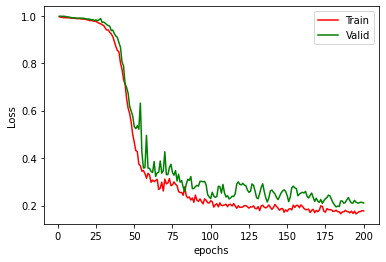

In [24]:
# plot the variation of train and validation losses vs n_epochs
loss=pd.read_csv('loss_epoch.csv',header=0,index_col=False)
plt.plot(loss['epoch'],loss['Training Loss'],'r',loss['epoch'],loss['Validation Loss'],'g')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(labels=['Train','Valid'])
plt.savefig('loss_epoch.png')

##Load  a trained model

In [25]:
# load the model that got the minimum validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Generate predictions

###Visualize and save the inference results

/content/inference.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,4))


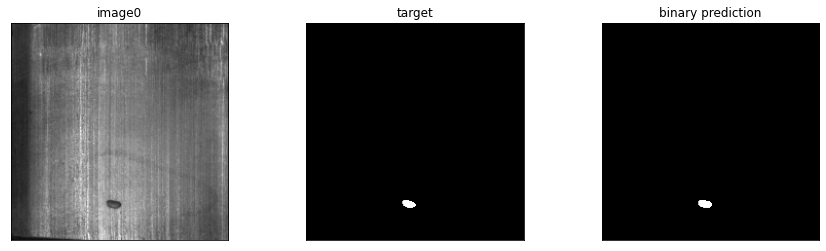

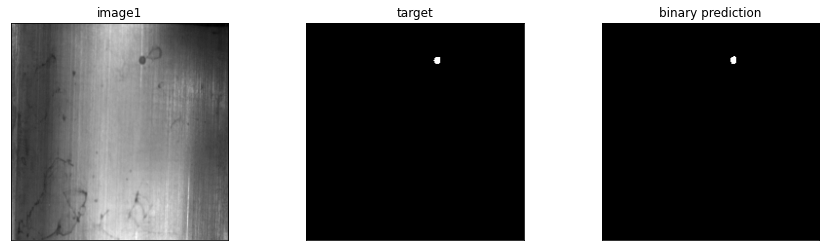

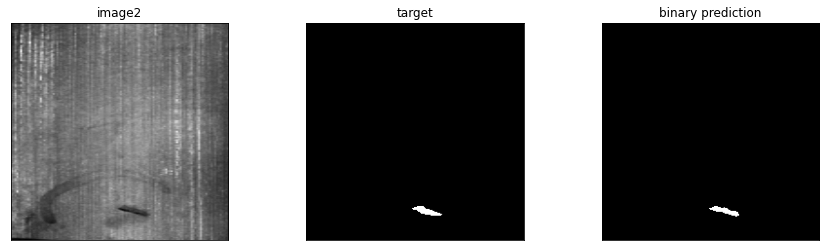

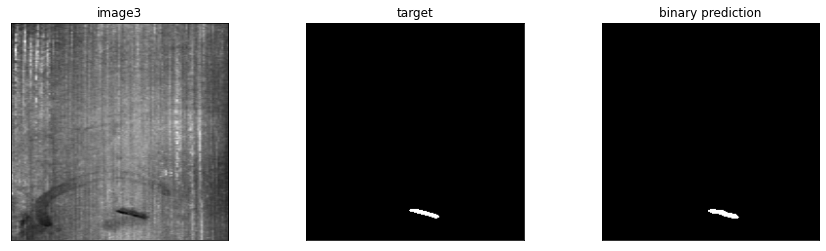

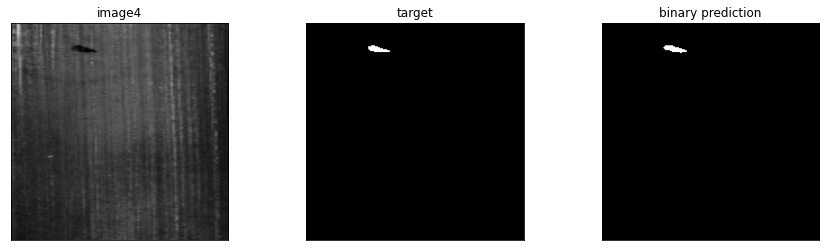

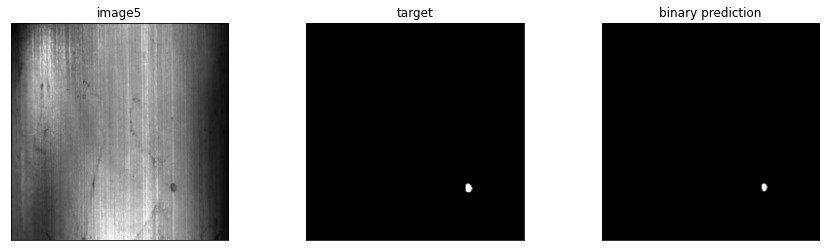

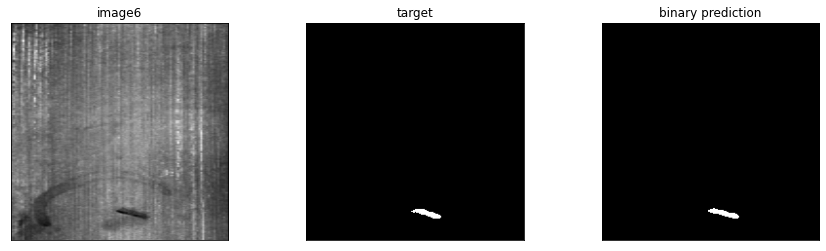

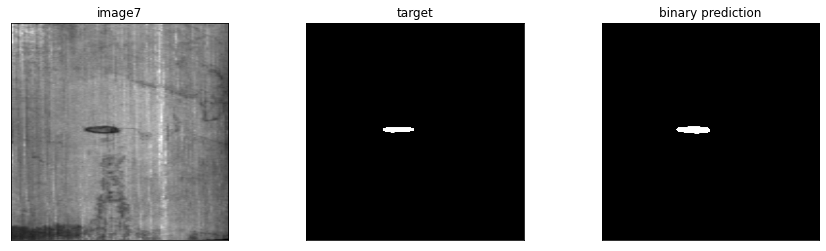

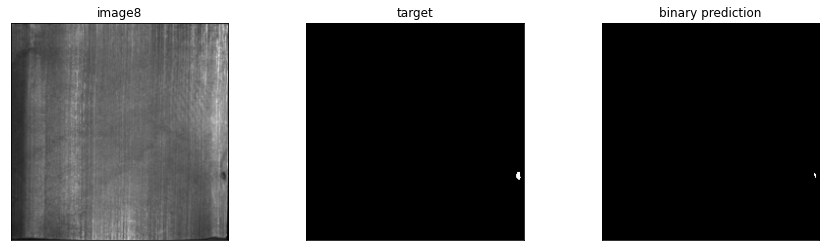

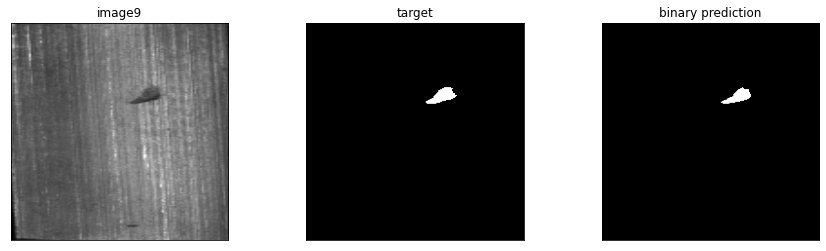

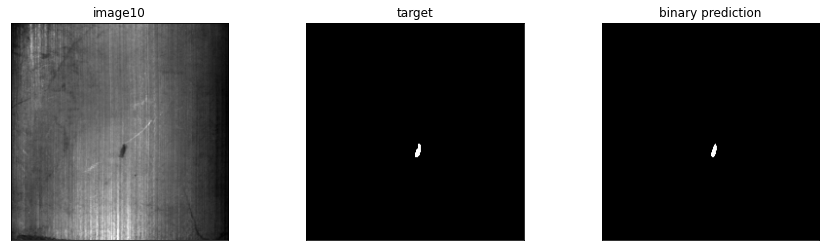

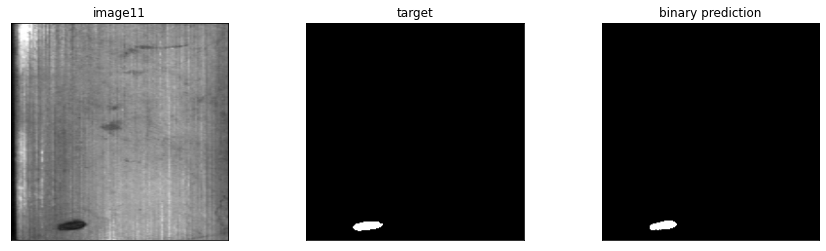

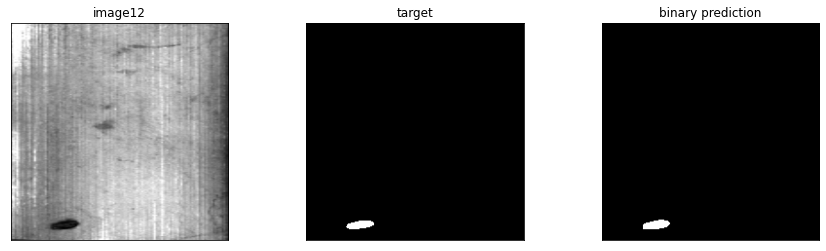

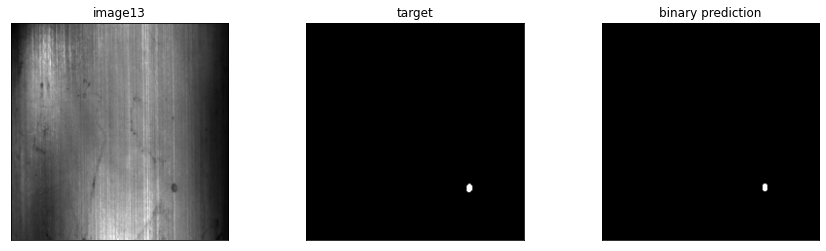

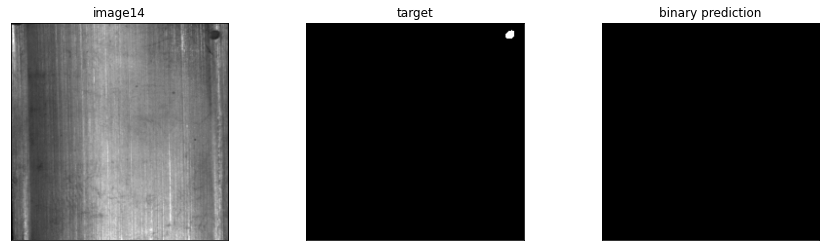

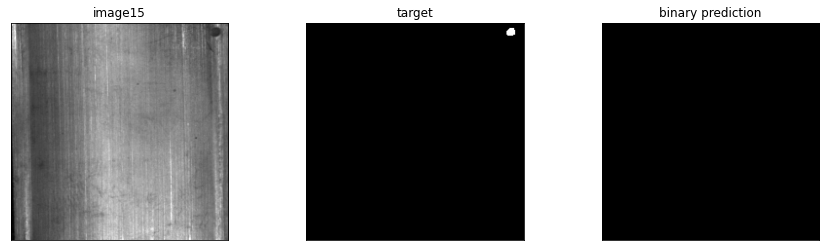

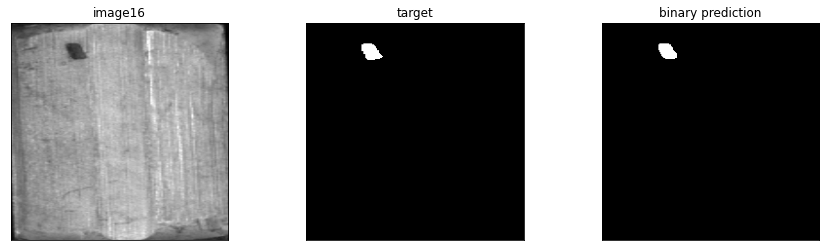

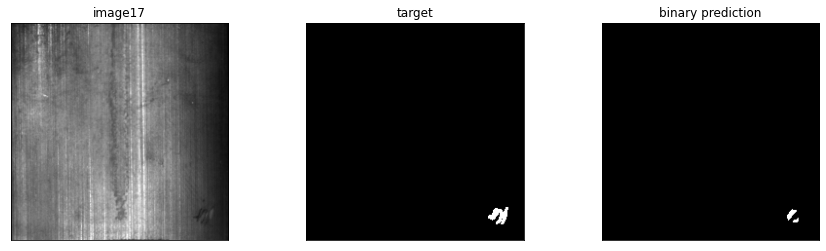

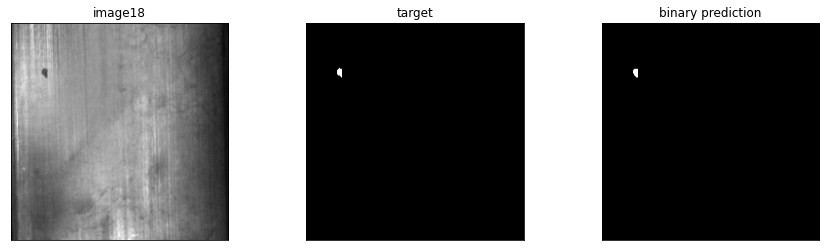

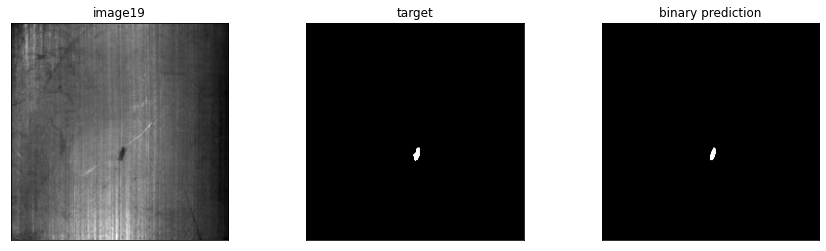

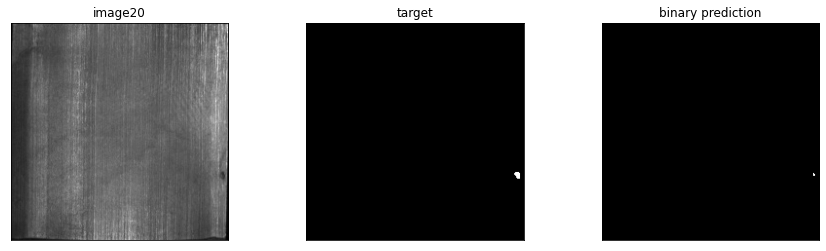

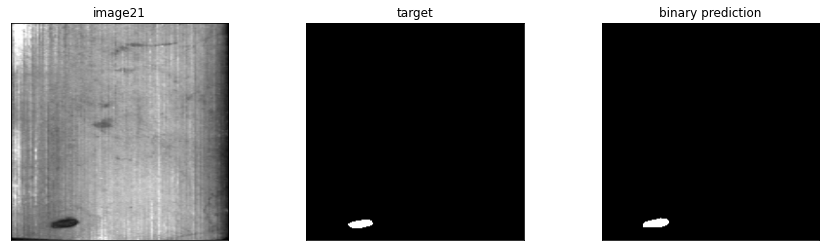

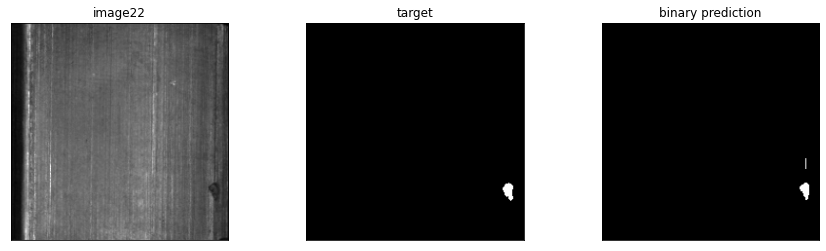

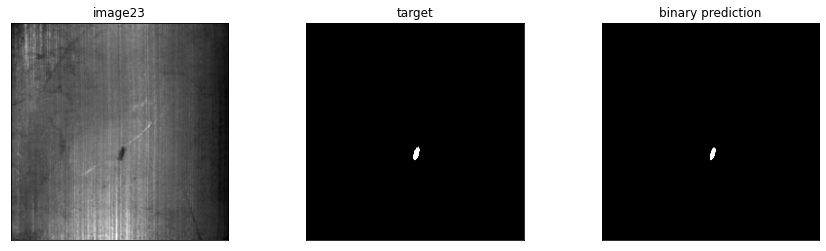

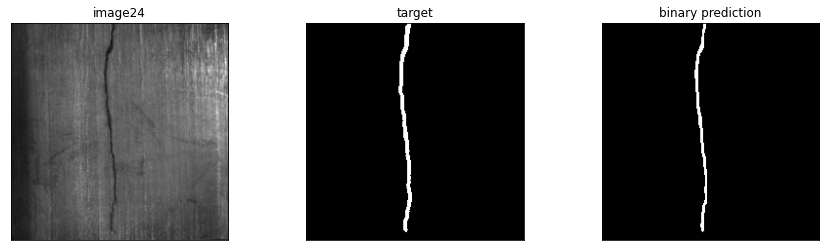

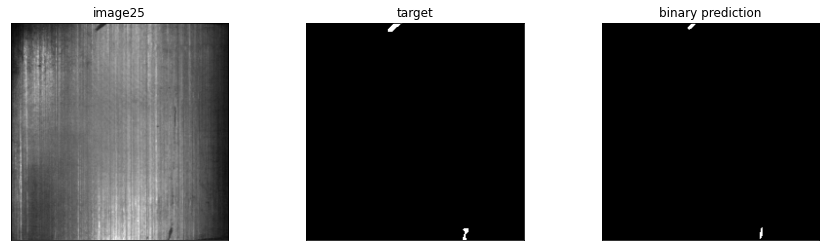

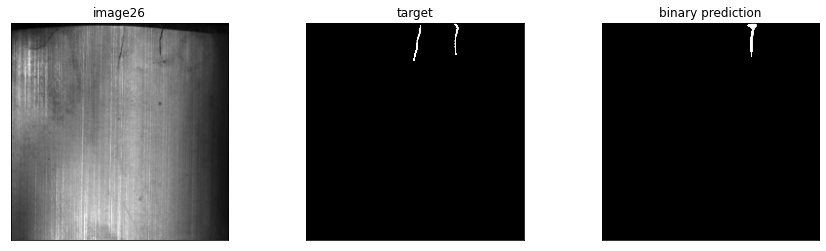

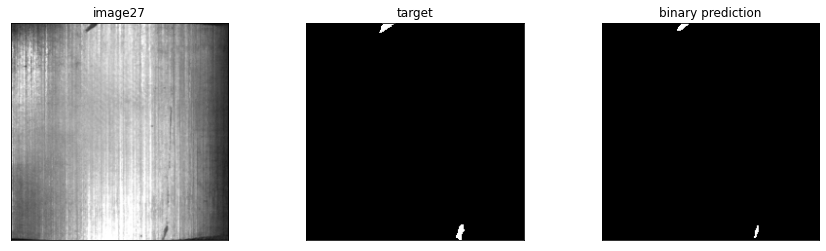

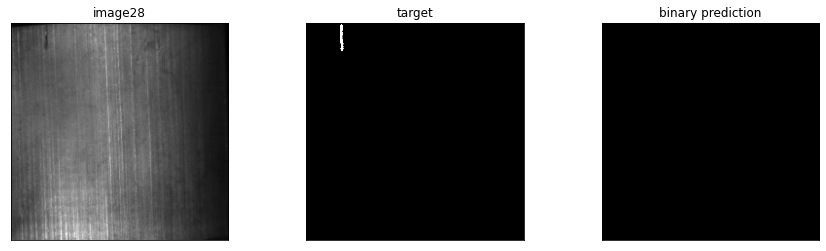

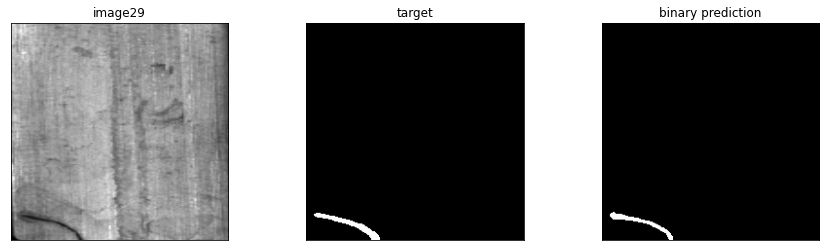

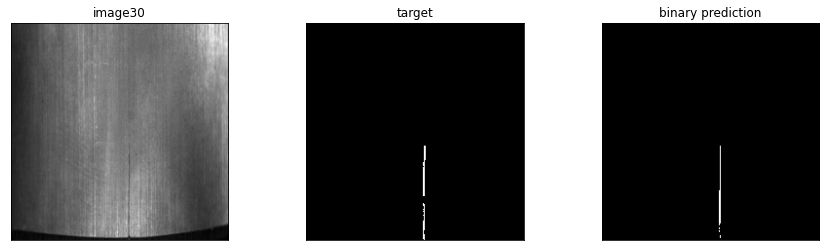

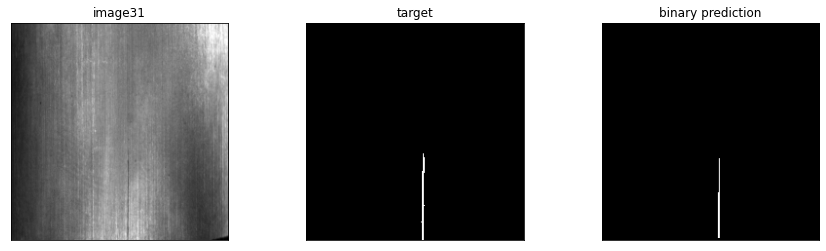

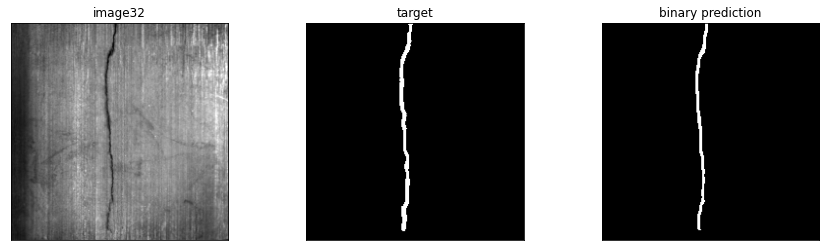

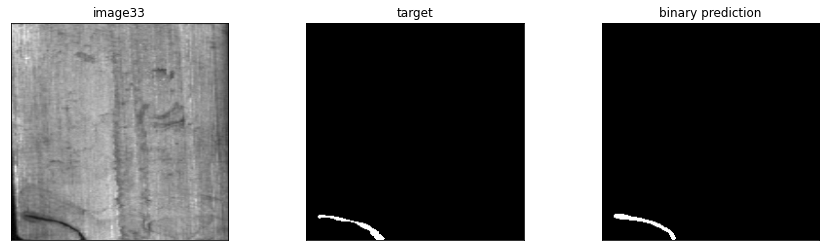

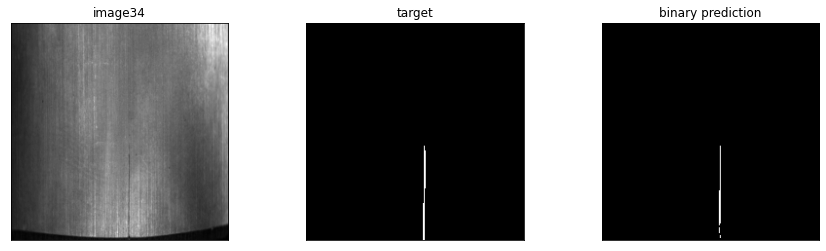

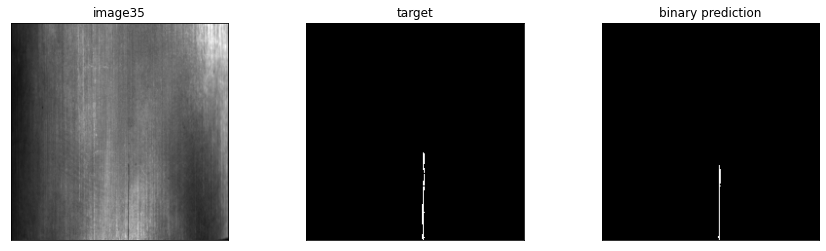

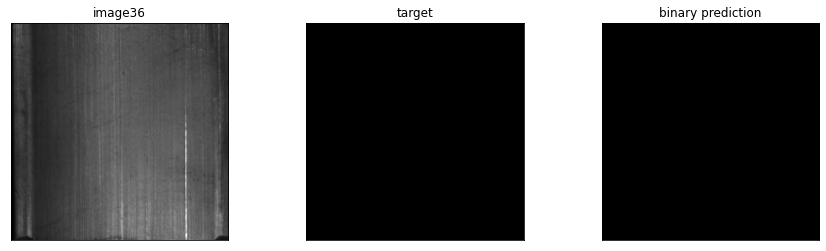

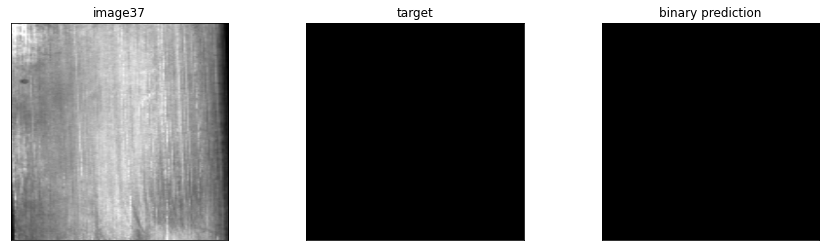

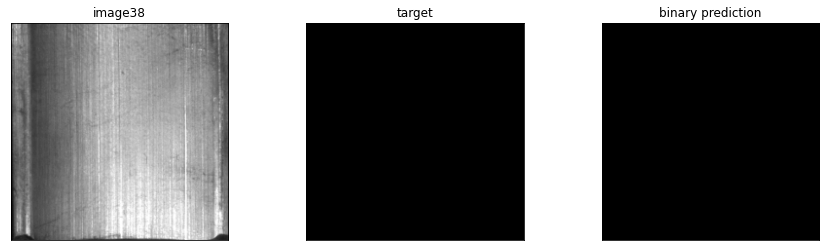

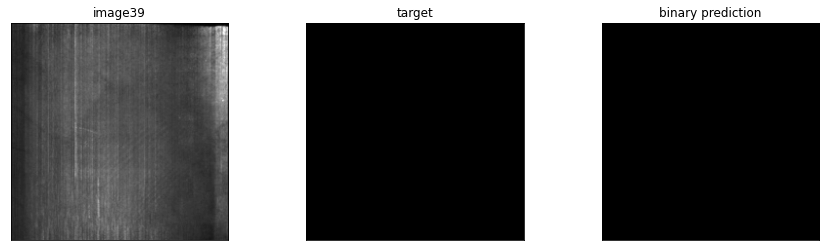

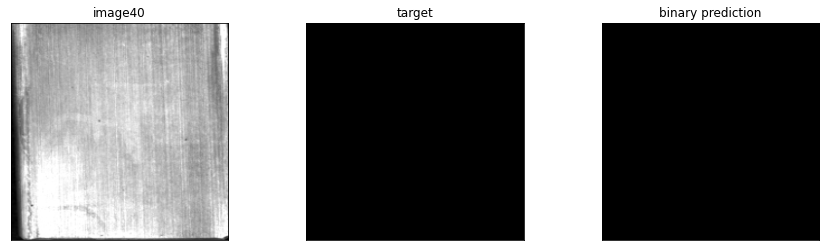

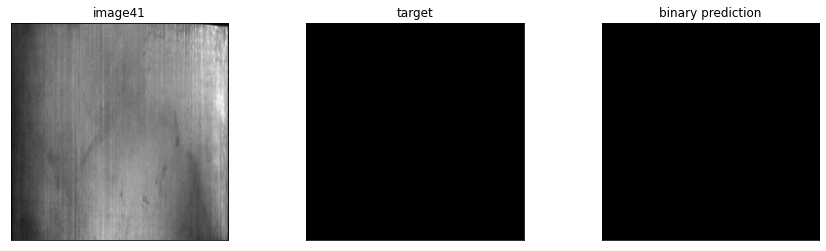

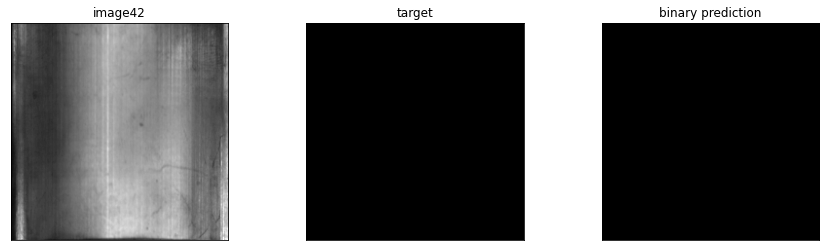

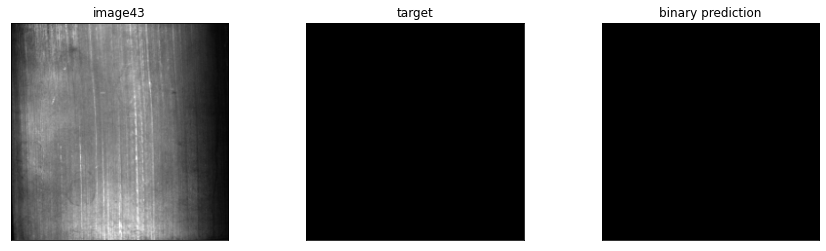

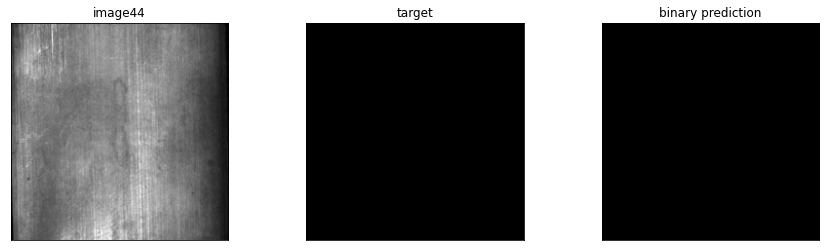

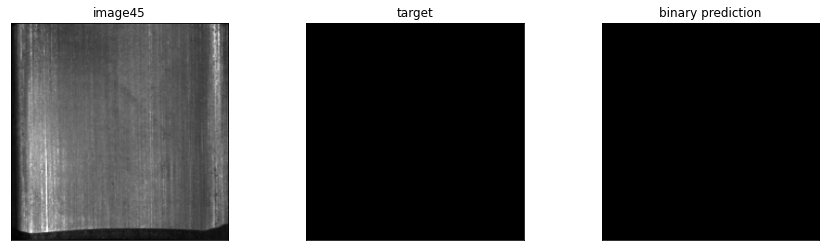

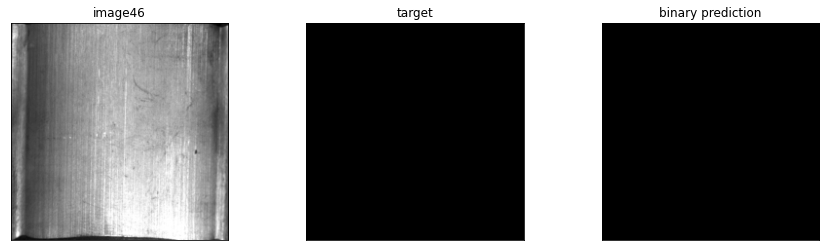

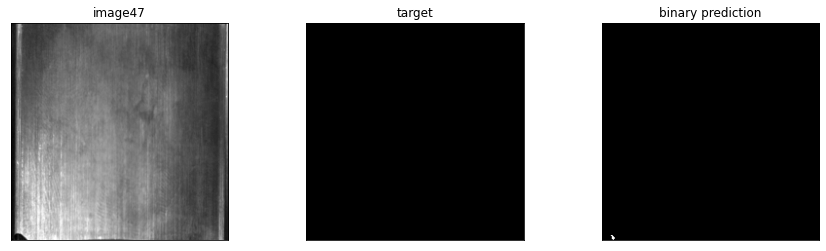

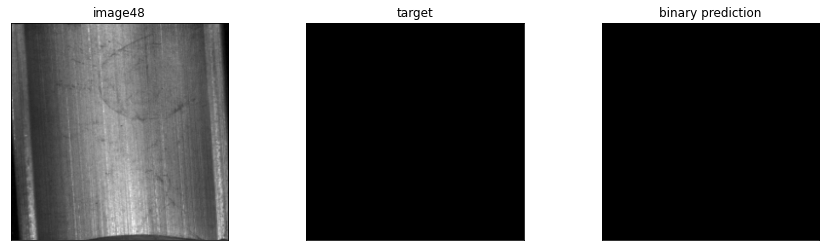

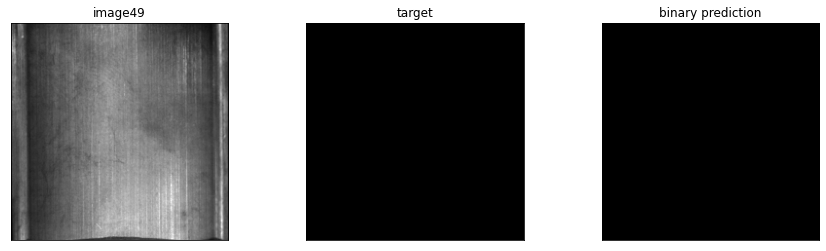

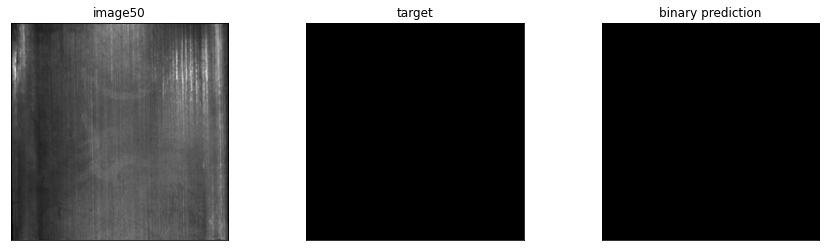

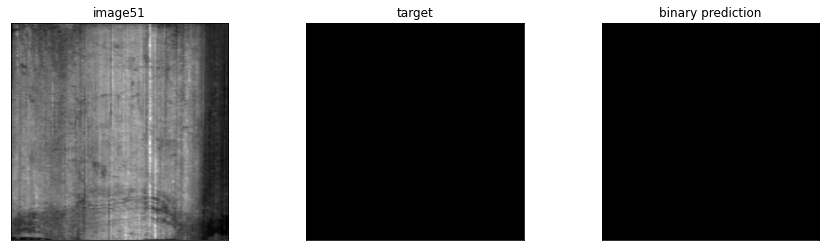

<Figure size 1080x288 with 0 Axes>

In [26]:
plot_prediction_results(model, train_on_gpu, loaders['test'], threshold)

###Get the inference performance metrics

In [27]:
df = get_inference_performance_metrics(model, train_on_gpu, loaders['test'], threshold)

In [28]:
###The inference performance metrics stats
df.describe()

,specificity,sensitivity,precision,F1_score,F2_score,DSC,F_beta,MAE,acc
count,53.000000,5.300000e+01,5.300000e+01,53.000000,5.300000e+01,5.300000e+01,53.000000,5.300000e+01,53.000000
mean,0.085958,6.448316e-02,6.753869e-02,0.074996,7.124217e-02,7.151483e-02,0.075854,5.789965e-05,0.085922
std,0.154047,1.547558e-01,1.435309e-01,0.144953,1.496680e-01,1.460801e-01,0.141864,8.070854e-05,0.154042
min,0.018868,1.751790e-110,2.544705e-110,0.012870,2.562427e-10,1.024692e-09,0.016442,1.113964e-74,0.018868
25%,0.025000,1.172761e-27,1.703590e-27,0.022222,2.040037e-02,2.140470e-02,0.022727,1.110408e-17,0.025000
50%,0.036989,1.931223e-02,2.976939e-02,0.026856,2.439026e-02,2.564104e-02,0.028732,3.986128e-05,0.036937
75%,0.071426,5.190311e-02,6.746042e-02,0.062500,5.294118e-02,5.457853e-02,0.065657,7.913331e-05,0.071412
max,0.999840,1.000000e+00,9.120879e-01,0.954023,9.810875e-01,9.540230e-01,0.930975,4.451002e-04,0.999841


In [29]:
#!pip install pipreqs
#!pipreqs
